In [43]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import acquire
import titanic_prep
import warnings as warn
warn.filterwarnings("ignore")
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer



In [34]:
titanic_df = acquire.get_titanic_data()

titanic_df.head()

,Unnamed: 0,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


In [35]:

titanic_df = titanic_df.drop_duplicates()
titanic_df = titanic_df.drop(columns=['deck', 'embarked', 'class', 'passenger_id', 'Unnamed: 0'])
titanic_df['embark_town'] = titanic_df.embark_town.fillna(value='Southampton')
dummy_df = pd.get_dummies(titanic_df[['sex', 'embark_town']], drop_first=True)
titanic_df = pd.concat([titanic_df, dummy_df], axis=1)

In [36]:
titanic_df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embark_town,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
0,0,3,male,22.0,1,0,7.2500,Southampton,0,1,0,1
1,1,1,female,38.0,1,0,71.2833,Cherbourg,0,0,0,0
2,1,3,female,26.0,0,0,7.9250,Southampton,1,0,0,1
3,1,1,female,35.0,1,0,53.1000,Southampton,0,0,0,1
4,0,3,male,35.0,0,0,8.0500,Southampton,1,1,0,1


In [37]:

titanic_train, titanic_test = train_test_split(titanic_df, test_size=.2, random_state=123, stratify=titanic_df.survived)
titanic_train, titanic_validate = train_test_split(titanic_train, test_size=.3, random_state=123, stratify=titanic_train.survived)

# Validate my split

print(f'train -> {titanic_train.shape}')
print(f'validate -> {titanic_validate.shape}')
print(f'test -> {titanic_test.shape}')


train -> (498, 12)
validate -> (214, 12)
test -> (179, 12)


In [38]:
imputer = SimpleImputer(missing_values = None, strategy='most_frequent')

imputer = imputer.fit(titanic_train[['embark_town']])


In [39]:
titanic_train[['embark_town']] = imputer.transform(titanic_train[['embark_town']])

titanic_validate[['embark_town']] = imputer.transform(titanic_validate[['embark_town']])

titanic_test[['embark_town']] = imputer.transform(titanic_test[['embark_town']])


In [40]:

titanic_train.embark_town.value_counts(dropna=False)

titanic_train.head()

,survived,pclass,sex,age,sibsp,parch,fare,embark_town,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
583,0,1,male,36.0,0,0,40.1250,Cherbourg,1,1,0,0
165,1,3,male,9.0,0,2,20.5250,Southampton,0,1,0,1
50,0,3,male,7.0,4,1,39.6875,Southampton,0,1,0,1
259,1,2,female,50.0,0,1,26.0000,Southampton,0,0,0,1
306,1,1,female,NaN,0,0,110.8833,Cherbourg,1,0,0,0


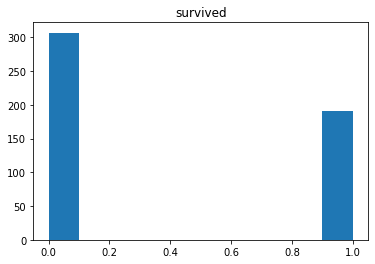

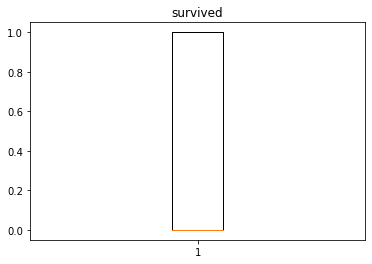

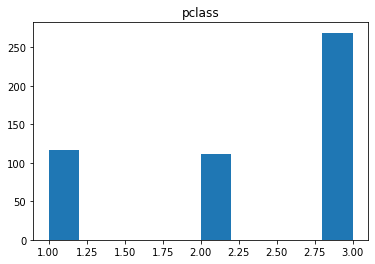

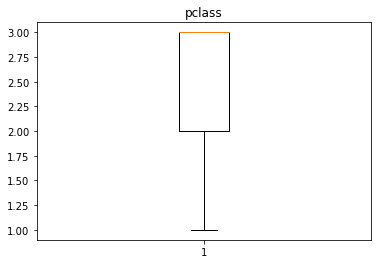

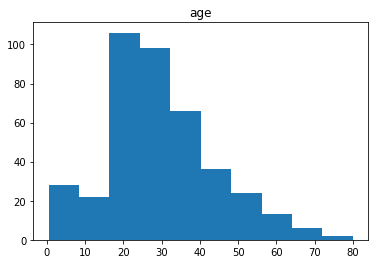

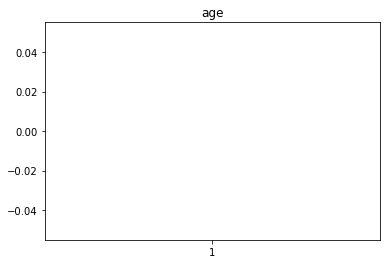

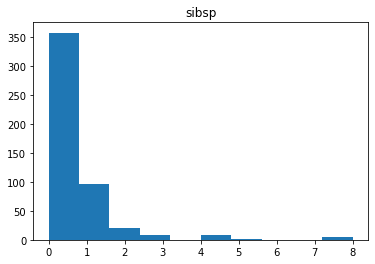

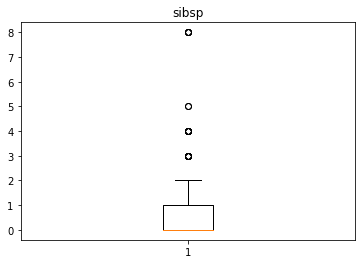

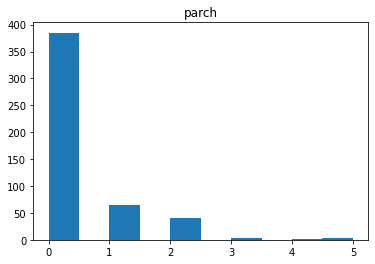

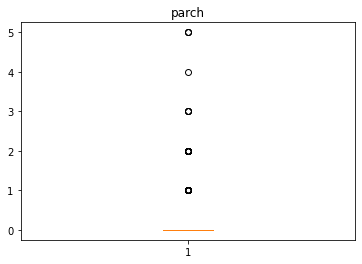

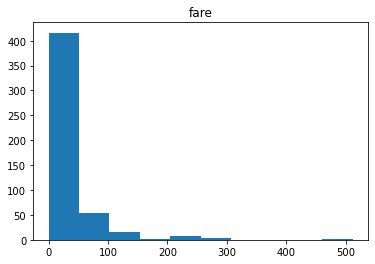

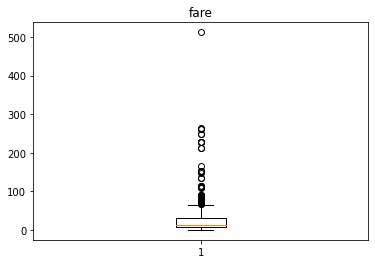

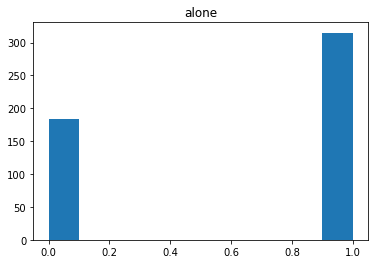

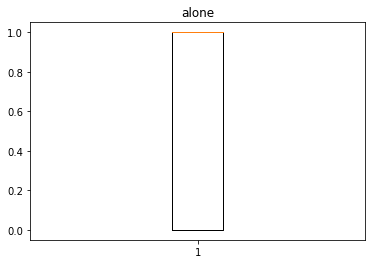

In [41]:
num_cols = titanic_train.columns[[(titanic_train[col].dtype == 'int64') or (titanic_train[col].dtype == 'float64') for col in titanic_train.columns]]
for col in num_cols:
    plt.hist(titanic_train[col])
    plt.title(col)
    plt.show()
    plt.boxplot(titanic_train[col])
    plt.title(col)
    plt.show()

First graph shows that most passengers did not survive

We can see by the class chart that the majority were in 3rd class with not much difference between 1st and 2nd

the age chart shows that we see most the passengers were in their 20s and drops off both sides, not quite normal distributions

The sibling chart shows a few outliers but the majority did not have siblings on the ship, the same can be applied for parents with children

Fare graph shows the vast majority paid under 50 with the second most popular tickets being under 100 

The last graph shows that more than half the passengers were traveling alone. 

In [42]:
titanic_train.head()

,survived,pclass,sex,age,sibsp,parch,fare,embark_town,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
583,0,1,male,36.0,0,0,40.1250,Cherbourg,1,1,0,0
165,1,3,male,9.0,0,2,20.5250,Southampton,0,1,0,1
50,0,3,male,7.0,4,1,39.6875,Southampton,0,1,0,1
259,1,2,female,50.0,0,1,26.0000,Southampton,0,0,0,1
306,1,1,female,NaN,0,0,110.8833,Cherbourg,1,0,0,0


Below I will graph a few variables against survival rate to find any relationships between the two

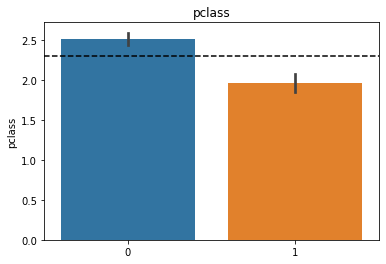

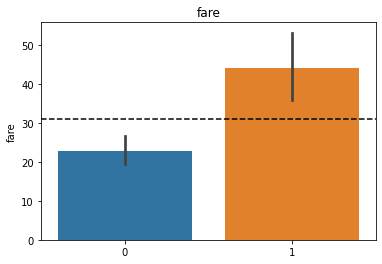

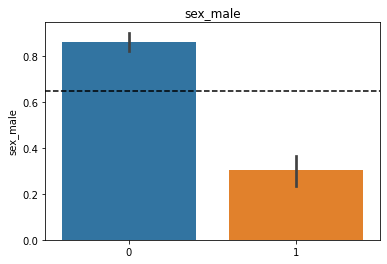

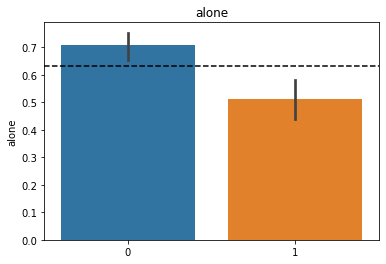

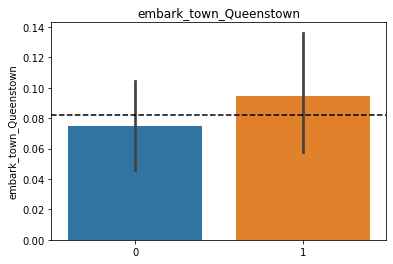

In [46]:
variables = ['pclass','fare','sex_male', 'alone', 'embark_town_Queenstown', 'age']

mean = [titanic_train['pclass'].mean(), titanic_train['fare'].mean(), titanic_train['sex_male'].mean(), titanic_train['alone'].mean(), titanic_train['embark_town_Queenstown'].mean(), titanic_train['age'].mean()]

for x in range(0,5):
    sns.barplot('survived',variables[x], data=titanic_train)
    
    plt.xlabel('')
    plt.title(variables[x])
    plt.axhline(mean[x], ls = '--', color = 'black')
    plt.show()